# Jesse's Task One

# 1. Setup

In [64]:
import sys

import numpy as np
import pandas as pd

import xgboost as xgb

In [23]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report

from category_encoders.target_encoder import TargetEncoder

In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio
import kaleido 
print('kaleido version:', kaleido.__version__)

#Inline figures
pio.renderers.default = 'iframe'

#Themeing
# mcolors = px.colors.qualitative.Dark24

pio.templates['custom'] = go.layout.Template(
    layout=dict(
        xaxis=dict(ticks='outside', tickcolor='lightgray', showgrid=False, showline=True),
        yaxis=dict(ticks='outside', tickcolor='lightgray', showgrid=False, showline=True, mirror=True),
        yaxis2=dict(ticks='outside', tickcolor='lightgray', showgrid=False,),
        # colorway=mcolors,
    )

)


pio.templates.default = 'plotly_white+custom'

kaleido version: 0.2.1


In [4]:
seed = 309

## 2. EDA

In [5]:
kyc = pd.read_csv('../data/raw/kyc.csv')
display(kyc.head(3))
display(kyc.dtypes)

,Name,Gender,Occupation,Age,Tenure,cust_id,label
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0
1,ANTHONY ADAMS,male,Musician,52.0,8.0,CUST69248708,0
2,DENISE LEWIS,female,Jewelry Dealer,43.0,11.0,CUST67222818,0


Name           object
Gender         object
Occupation     object
Age           float64
Tenure        float64
cust_id        object
label           int64
dtype: object

In [6]:
kyc.groupby('label')[['Age', 'Tenure']].describe()

Age                                                        Tenure  \
          count       mean        std   min   25%   50%   75%   max     count   
label                                                                           
0      190275.0  35.670687  10.662419  18.0  28.0  35.0  42.0  92.0  190275.0   
1        5514.0  41.428908  10.984981  18.0  34.0  41.0  49.0  80.0    5514.0   

                                                      
           mean       std  min  25%  50%   75%   max  
label                                                 
0      6.431917  5.925174  0.0  2.0  5.0  10.0  49.0  
1      9.859086  7.400461  0.0  4.0  9.0  15.0  41.0

In [7]:
plot_df = kyc.groupby('Age')['label'].agg(Count='count', Sum='sum', Mean='mean')

fig = make_subplots(rows=1, cols=len(plot_df.columns), subplot_titles=plot_df.columns.values, x_title='Age')

for i, stat in enumerate(plot_df.columns): 
    fig.append_trace(go.Bar(
        x=plot_df.index.values,
        y=plot_df[stat], 
        showlegend=False
    ), row=1, col=i+1)
    
    fig.update_layout()
    
fig.show()

In [8]:
plot_df = kyc.groupby('Tenure')['label'].agg(Count='count', Sum='sum', Mean='mean')

fig = make_subplots(rows=1, cols=len(plot_df.columns), subplot_titles=plot_df.columns.values, x_title='Tenure')

for i, stat in enumerate(plot_df.columns): 
    fig.append_trace(go.Bar(
        x=plot_df.index.values,
        y=plot_df[stat], 
        showlegend=False
    ), row=1, col=i+1)
    
    fig.update_layout()

fig.show()

In [9]:
plot_df = kyc.groupby('Gender')['label'].agg(Count='count', Sum='sum', Mean='mean')

fig = make_subplots(rows=1, cols=len(plot_df.columns), subplot_titles=plot_df.columns.values, x_title='Gender')

for i, stat in enumerate(plot_df.columns): 
    fig.append_trace(go.Bar(
        x=plot_df.index.values,
        y=plot_df[stat], 
        showlegend=False
    ), row=1, col=i+1)
    
    fig.update_layout()

fig.show()

In [10]:
x = pd.crosstab(kyc['Occupation'], kyc['label']).reset_index()
x['freq'] = x[1]/(x[0]+x[1])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(x.sort_values('freq', ascending=False))

label                                        Occupation     0    1      freq
110                        Import/Export Business Owner   143  105  0.423387
160                       Online Gambling Site Operator   100   68  0.404762
90                             Free Trade Zone Operator   103   69  0.401163
153                                       Notary Public   201  134  0.400000
55                                Cryptocurrency Trader   127   84  0.398104
232                  Trust and Company Service Provider   127   83  0.395238
32                                 Car Dealership Owner   255  161  0.387019
187                                  Private Jet Broker    68   42  0.381818
139                          Maritime or Shipping Agent   130   80  0.380952
129                       Loan or Finance Company Owner   124   76  0.380000
230                                 Travel Agency Owner   186  114  0.380000
195                                  Real Estate Broker   295  178  0.376321

## 3. Modeling
### 3.1 Brute Force
Occupations are one-hot encoded

In [11]:
#Training Data
train_df = pd.read_csv('../data/train/kyc_train.csv')
Xtrain, ytrain = train_df[['Gender', 'Age', 'Occupation', 'Tenure']], train_df[['label']]
Xtrain = pd.concat([Xtrain, pd.get_dummies(Xtrain['Gender']), pd.get_dummies(Xtrain['Occupation'])], axis=1)
Xtrain = Xtrain.drop(['Gender', 'Occupation'], axis=1)

#Validation Data
val_df = pd.read_csv('../data/val/kyc_val.csv')
Xval, yval = val_df[['Gender', 'Age', 'Occupation', 'Tenure']], val_df[['label']]
Xval = pd.concat([Xval, pd.get_dummies(Xval['Gender']), pd.get_dummies(Xval['Occupation'])], axis=1)
Xval = Xval.drop(['Gender', 'Occupation'], axis=1)

#Column alignment
#https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
missing_cols = set(Xtrain.columns) - set(Xval.columns)
for c in missing_cols:
    Xval[c] = 0
Xval = Xval[Xtrain.columns]

In [12]:
rf_clf = RandomForestClassifier(max_depth=3, n_estimators=500, random_state=seed)
rf_clf.fit(Xtrain, ytrain.values.ravel())

RandomForestClassifier(max_depth=3, n_estimators=500, random_state=309)

In [13]:
preds = rf_clf.predict(Xval)

print(classification_report(yval, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     38050
           1       0.00      0.00      0.00      1108

    accuracy                           0.97     39158
   macro avg       0.49      0.50      0.49     39158
weighted avg       0.94      0.97      0.96     39158



C:\Users\jesse\miniconda3\envs\bigdata\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\jesse\miniconda3\envs\bigdata\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\jesse\miniconda3\envs\bigdata\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [14]:
# Compute ROC curve and AUC
probs = rf_clf.predict_proba(Xval)[:,1]
fpr, tpr, threshold = roc_curve(yval, probs)
roc_auc = auc(fpr, tpr)
print(roc_auc)

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=fpr, y=tpr, showlegend=False)
)

fig.add_trace(
    go.Scatter(
        x=[0,1],
        y=[0,1],
        mode='lines',
        showlegend=False,
        line_color='#000000',
        line_dash='dash'
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    width=500, height=500,
    yaxis_range=[0,1],
    xaxis_range=[0,1]
)

fig.show()

0.8219194651726542


This method predicts 0 for everything - not great. In our case false positives are more desirable than false negatives, since people can always be flagged, investigated, and then removed from the "at risk" list. We can try a random forest again with a much higher weight for postive (y=1) labels.

### 3.2 Weighted Random Forest

In [15]:
#Training Data
train_df = pd.read_csv('../data/train/kyc_train.csv')
Xtrain, ytrain = train_df[['Gender', 'Age', 'Occupation', 'Tenure']], train_df[['label']]
Xtrain = pd.concat([Xtrain, pd.get_dummies(Xtrain['Gender']), pd.get_dummies(Xtrain['Occupation'])], axis=1)
Xtrain = Xtrain.drop(['Gender', 'Occupation'], axis=1)

#Validation Data
val_df = pd.read_csv('../data/val/kyc_val.csv')
Xval, yval = val_df[['Gender', 'Age', 'Occupation', 'Tenure']], val_df[['label']]
Xval = pd.concat([Xval, pd.get_dummies(Xval['Gender']), pd.get_dummies(Xval['Occupation'])], axis=1)
Xval = Xval.drop(['Gender', 'Occupation'], axis=1)

#Column alignment
#https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
missing_cols = set(Xtrain.columns) - set(Xval.columns)
for c in missing_cols:
    Xval[c] = 0
Xval = Xval[Xtrain.columns]

In [16]:
cweights = {1:30, 0:1}

In [17]:
rf_clf = RandomForestClassifier(max_depth=5, n_estimators=500, random_state=seed, class_weight=cweights)
rf_clf.fit(Xtrain, ytrain.values.ravel())

RandomForestClassifier(class_weight={0: 1, 1: 30}, max_depth=5,
                       n_estimators=500, random_state=309)

In [18]:
preds = rf_clf.predict(Xval)

print(classification_report(yval, preds))
print(f'{sum(preds)/len(preds):.3f}% of data positively labelled')

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     38050
           1       0.11      0.43      0.18      1108

    accuracy                           0.89     39158
   macro avg       0.55      0.66      0.56     39158
weighted avg       0.96      0.89      0.92     39158

0.106% of data positively labelled


In [19]:
# Compute ROC curve and AUC
probs = rf_clf.predict_proba(Xval)[:,1]
fpr, tpr, threshold = roc_curve(yval, probs)
roc_auc = auc(fpr, tpr)
print(roc_auc)

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=fpr, y=tpr, showlegend=False)
)

fig.add_trace(
    go.Scatter(
        x=[0,1],
        y=[0,1],
        mode='lines',
        showlegend=False,
        line_color='#000000',
        line_dash='dash'
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    width=500, height=500,
    yaxis_range=[0,1],
    xaxis_range=[0,1]
)

fig.show()

0.7802537630990953


#### 3.2.1 Tuning

In [20]:
pos_weights = [5, 10, 20, 40, 80]

pos_pres = []
pos_rec = []
neg_pres = []
neg_rec  = []

for w in pos_weights:
    cweights={1:w, 0:1}
    rf_clf = RandomForestClassifier(max_depth=5, n_estimators=500, random_state=seed, class_weight=cweights)
    rf_clf.fit(Xtrain, ytrain.values.ravel())
    preds = rf_clf.predict(Xval)

    outputs = classification_report(yval, preds, output_dict=True)
    pos_pres.append(outputs['1']['precision'])
    pos_rec.append(outputs['1']['recall'])
    neg_pres.append(outputs['0']['precision'])
    neg_rec.append(outputs['0']['recall'])

C:\Users\jesse\miniconda3\envs\bigdata\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\jesse\miniconda3\envs\bigdata\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\jesse\miniconda3\envs\bigdata\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\jesse\miniconda3\envs\bigdata\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being s

In [21]:
b = px.colors.qualitative.Set1
d = px.colors.qualitative.Pastel1

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=pos_weights,
        y=pos_rec,
        name='1 Recall',
        mode='lines',
        line_color=b[0]
))

fig.add_trace(
    go.Scatter(
        x=pos_weights,
        y=pos_pres,
        name='1 Precision',
        mode='lines',
        line_color= d[0]
))


fig.add_trace(
    go.Scatter(
        x=pos_weights,
        y=neg_rec,
        name='0 Recall',
        mode='lines',
        line_color=b[1]
))

fig.add_trace(
    go.Scatter(
        x=pos_weights,
        y=neg_pres,
        name='0 Precision',
        mode='lines',
        line_color=d[1]
))



fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    height=500,
    yaxis_range=[-0.01,1.1],
    xaxis_title='Positive Class Weight'
)

fig.show()

### 3.3 Weighted Random Forest with Occupation Target Mean Encoding

In [32]:
#Training Data
train_df = pd.read_csv('../data/train/kyc_train.csv')
Xtrain, ytrain = train_df[['Gender', 'Age', 'Occupation', 'Tenure']], train_df[['label']]
Xtrain = pd.concat([Xtrain, pd.get_dummies(Xtrain['Gender'])], axis=1)
Xtrain = Xtrain.drop(['Gender'], axis=1)

#Validation Data
val_df = pd.read_csv('../data/val/kyc_val.csv')
Xval, yval = val_df[['Gender', 'Age', 'Occupation', 'Tenure']], val_df[['label']]
Xval = pd.concat([Xval, pd.get_dummies(Xval['Gender'])], axis=1)
Xval = Xval.drop(['Gender'], axis=1)


#Column alignment
#https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
missing_cols = set(Xtrain.columns) - set(Xval.columns)
for c in missing_cols:
    Xval[c] = 0
Xval = Xval[Xtrain.columns]

In [34]:
# set up the encoder
encoder = TargetEncoder(cols=['Occupation'])

# fit the encoder - finds the mean target value per category
encoder.fit(Xtrain, ytrain)

# transform data
Xtrain_enc = encoder.transform(Xtrain)
Xval_enc = encoder.transform(Xval)

In [55]:
cweights = {1:22, 0:1}

In [56]:
rf_clf = RandomForestClassifier(max_depth=3, n_estimators=500, random_state=seed, class_weight=cweights)
rf_clf.fit(Xtrain_enc, ytrain.values.ravel())

RandomForestClassifier(class_weight={0: 1, 1: 22}, max_depth=3,
                       n_estimators=500, random_state=309)

In [57]:
preds = rf_clf.predict(Xval_enc)

print(classification_report(yval, preds))
print(f'{sum(preds)/len(preds):.3f}% of data positively labelled')

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     38050
           1       0.13      0.75      0.22      1108

    accuracy                           0.85     39158
   macro avg       0.56      0.80      0.56     39158
weighted avg       0.97      0.85      0.89     39158

0.169% of data positively labelled


In [59]:
# Compute ROC curve and AUC
probs = rf_clf.predict_proba(Xval_enc)[:,1]
fpr, tpr, threshold = roc_curve(yval, probs)
roc_auc = auc(fpr, tpr)
print(roc_auc)

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=fpr, y=tpr, showlegend=False)
)

fig.add_trace(
    go.Scatter(
        x=[0,1],
        y=[0,1],
        mode='lines',
        showlegend=False,
        line_color='#000000',
        line_dash='dash'
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    width=500, height=500,
    yaxis_range=[0,1],
    xaxis_range=[0,1]
)

fig.show()

0.8728315156287803


## 3.4 XGboost with Occupation Target Mean Encoding

In [156]:
#Training Data
train_df = pd.read_csv('../data/train/kyc_train.csv')
Xtrain, ytrain = train_df[['Gender', 'Age', 'Occupation', 'Tenure']], train_df[['label']]
Xtrain = pd.concat([Xtrain, pd.get_dummies(Xtrain['Gender'])], axis=1)
Xtrain = Xtrain.drop(['Gender'], axis=1)

#Validation Data
val_df = pd.read_csv('../data/val/kyc_val.csv')
Xval, yval = val_df[['Gender', 'Age', 'Occupation', 'Tenure']], val_df[['label']]
Xval = pd.concat([Xval, pd.get_dummies(Xval['Gender'])], axis=1)
Xval = Xval.drop(['Gender'], axis=1)


#Column alignment
#https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
missing_cols = set(Xtrain.columns) - set(Xval.columns)
for c in missing_cols:
    Xval[c] = 0
Xval = Xval[Xtrain.columns]

In [157]:
# set up the encoder
encoder = TargetEncoder(cols=['Occupation'])

# fit the encoder - finds the mean target value per category
encoder.fit(Xtrain, ytrain)

# transform data
Xtrain_enc = encoder.transform(Xtrain)
Xval_enc = encoder.transform(Xval)

In [159]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(Xtrain_enc, label=ytrain)
dval = xgb.DMatrix(Xval_enc, label=yval)

# Define parameters (can be tuned)
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': float(sum(ytrain.values==0) / sum(ytrain.values==1))
}

# Train the model
num_rounds = 1000
bst = xgb.train(params, dtrain, num_rounds)

In [160]:
xgb_preds = [round(x) for x in bst.predict(dval)]

# Classification report
print(classification_report(yval, xgb_preds))

# How much data was positively labeled
print(f'{sum(xgb_preds)/len(preds):.3f}% of data positively labelled')

# Compute ROC curve and AUC
probs = rf_clf.predict_proba(Xval_enc)[:,1]
fpr, tpr, threshold = roc_curve(yval, probs)
roc_auc = auc(fpr, tpr)
print(f'\nroc: {roc_auc:.3f}')

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     38050
           1       0.11      0.80      0.19      1108

    accuracy                           0.81     39158
   macro avg       0.55      0.80      0.54     39158
weighted avg       0.97      0.81      0.87     39158

0.211% of data positively labelled

roc: 0.873


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

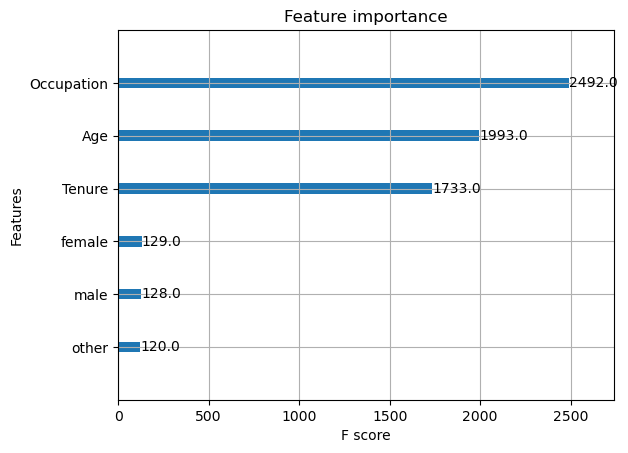

In [162]:
from matplotlib import pyplot as plt
from xgboost import plot_importance
plot_importance(bst)

#### 3.4.1 Tuning

In [142]:
depths = [2, 3, 4, 5, 6, 7, 8, 9 ,10]

pos_pres = []
pos_rec = []
neg_pres = []
neg_rec  = []
pos_lab = []


for d in depths: 
    # Define parameters (can be tuned)
    params = {
        'max_depth': d,
        'eta': 0.1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': float(sum(ytrain.values==0) / sum(ytrain.values==1))
    }
    

    # Train the model
    num_rounds = 500
    bst = xgb.train(params, dtrain, num_rounds)
    
    xgb_preds = [round(x) for x in bst.predict(dval)]

    outputs = classification_report(yval, xgb_preds, output_dict=True)
    pos_pres.append(outputs['1']['precision'])
    pos_rec.append(outputs['1']['recall'])
    neg_pres.append(outputs['0']['precision'])
    neg_rec.append(outputs['0']['recall'])
    pos_lab.append(sum(xgb_preds)/len(xgb_preds)*100)

In [144]:
b = px.colors.qualitative.Set1
d = px.colors.qualitative.Pastel1

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=depths,
        y=pos_rec,
        name='1 Recall',
        mode='lines',
        line_color=b[0]
))

fig.add_trace(
    go.Scatter(
        x=depths,
        y=pos_pres,
        name='1 Precision',
        mode='lines',
        line_color= d[0]
))


fig.add_trace(
    go.Scatter(
        x=depths,
        y=neg_rec,
        name='0 Recall',
        mode='lines',
        line_color=b[1]
))

fig.add_trace(
    go.Scatter(
        x=depths,
        y=neg_pres,
        name='0 Precision',
        mode='lines',
        line_color=d[1]
))



fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    height=500,
    yaxis_range=[-0.01,1.1],
    xaxis_title='Tree Depth'
)

fig.add_trace(
    go.Scatter(
        x=depths,
        y=pos_lab,
        name='% Positively Labelled',
        mode='lines',
        line_color='#000000',
        line_dash='dash'
        
), secondary_y=True)


fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    height=500,
    yaxis_range=[0,1],
    yaxis2_range=[0,50],
    yaxis2_title='% Positively Labelled',
    xaxis_title='Depth'
)

fig.show()

In [154]:
weights = list(range(10, 50, 5))

pos_pres = []
pos_rec = []
neg_pres = []
neg_rec  = []
pos_lab = []

for w in weights: 
    # Define parameters (can be tuned)
    params = {
        'max_depth': 1,
        'eta': 0.1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': w
    }
    

    # Train the model
    num_rounds = 1000
    bst = xgb.train(params, dtrain, num_rounds)
    
    xgb_preds = [round(x) for x in bst.predict(dval)]

    outputs = classification_report(yval, xgb_preds, output_dict=True)
    pos_pres.append(outputs['1']['precision'])
    pos_rec.append(outputs['1']['recall'])
    neg_pres.append(outputs['0']['precision'])
    neg_rec.append(outputs['0']['recall'])
    pos_lab.append(sum(xgb_preds)/len(xgb_preds)*100)

In [155]:
b = px.colors.qualitative.Set1
d = px.colors.qualitative.Pastel1

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=weights,
        y=pos_rec,
        name='1 Recall',
        mode='lines',
        line_color=b[0]
))

fig.add_trace(
    go.Scatter(
        x=weights,
        y=pos_pres,
        name='1 Precision',
        mode='lines',
        line_color= d[0]
))


fig.add_trace(
    go.Scatter(
        x=weights,
        y=neg_rec,
        name='0 Recall',
        mode='lines',
        line_color=b[1]
))

fig.add_trace(
    go.Scatter(
        x=weights,
        y=neg_pres,
        name='0 Precision',
        mode='lines',
        line_color=d[1]
))


fig.add_trace(
    go.Scatter(
        x=weights,
        y=pos_lab,
        name='% Positively Labelled',
        mode='lines',
        line_color='#000000',
        line_dash='dash'
        
), secondary_y=True)


fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    height=500,
    yaxis_range=[0,1],
    yaxis2_range=[0,50],
    yaxis2_title='% Positively Labelled',
    xaxis_title='Weights'
)

fig.show()